## Training Models

Looking at 2 ways of training linear regression model
- Using direct closed form equation, that directly computes the model parameters that best fit the model to the training set
- using iterative optimaztion approach called GD that gradually tweaks the model parameters to minimize the cost function over the trainng set. Variants of the GD:
    - batch GD
    - mini batch GD 
    - Stochastic GD

After this, we look at the polynomial regression (more complex model that can fit non linear datasets). This model has more parameters than a linear regression, it is more prone to overfitting the training data. 

#### Linear Regression 

In Chapter 1, we saw the equation for the simple regression model of the life satisfaction:

\begin{equation*} life\_satisfaction = θ_{0} + θ_1 * GDP\_per\_capita\end{equation*}

Here, GDP_per_capita is input variable, θ_0 and θ_1 are model's parameters.  θ_0 is a constant term called bias. 

\begin{equation*} y^ˆ = θ_{0} + θ_1x_1 + θ_2x_2 + .... +  θ_nx_n \end{equation*}

Here, 
- y^ is the predicted value
- n is the number of features
- xi is the ith feature value
- θj is the jth model parameter

Vectorized form of the above equation,

\begin{equation*} y^ˆ = h_{θ}(x) = θ.x \end{equation*}

Here, 
- θ is the model's parameter vector (incl. θ0)
- x is feature vector
- θ.x is the dot product of the vector θ and c
- hθ is the hypothesis function

To check the accuracy we check the deviation of the y^ with the y_actual using mean square error and root mean square error. 


##### The normal equation  

To find the value of θ that minimizes the cost function, there is a _closed-form solution_ —in other words, a mathematical equation that gives the result
directly. This is called the _Normal Equation_

 \begin{equation*} θ^ˆ = (X ^{⊺}X)^{-1}X ^{⊺}y  \end{equation*} 

- θˆ is the value of θ that minimizes the cost function
- y is the vector of target values 

In [1]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

(0.0, 2.0, 0.0, 15.0)

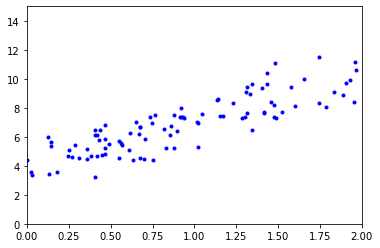

In [2]:
import matplotlib.pyplot as plt

plt.plot(X,y,"b.")
plt.axis([0,2,0,15])

Computing θ^ˆ using normal equation. Using ```inv()``` from numpy linear algebra module (```np.linalg```) to compute the inverse of the matrix and the ```dot()``` to compute the matrix multiplication. 

In [3]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best) 

[[3.99917433]
 [3.09393849]]


This function predicted y = 4 + 3x_1 + gaussian noise. The actual values expected were (4,3) for (θ0,θ1). The deivation occurs due to the noise. We can make predictions using the values we got for θ^

In [4]:
## Predicting 
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.99917433],
       [10.18705131]])

(0.0, 2.0, 0.0, 15.0)

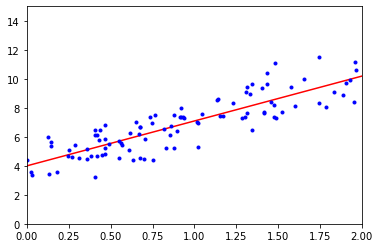

In [5]:
## Ploting the model predictions
plt.plot(X_new,y_predict,"r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])

In [8]:
## Method 2 using scikit lern
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_)
print(lin_reg.coef_)
print(lin_reg.predict(X_new))

[3.99917433]
[[3.09393849]]
[[ 3.99917433]
 [10.18705131]]


The LinearRegression class is based on the ```scipy.linalg.lstsq()```
function (the name stands for “least squares”), which we can call directly

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print(theta_best_svd)

[[3.99917433]
 [3.09393849]]


This function computes ```ˆθ = X+y```, where X+ is the pseudoinverse of X
(specifically, the [Moore-Penrose inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse)). can use ```np.linalg.pinv()``` to compute the pseudoinverse directly:

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[3.99917433],
       [3.09393849]])

The pseudoinverse itself is computed using a standard matrix factorization
technique called _Singular Value Decomposition (SVD)_ that can decompose
the training set matrix X into the matrix multiplication of three matrices U Σ
VT (see ```numpy.linalg.svd()```)

##### Computational Complexity
The Normal Equation computes the inverse of XTX, which is an (n + 1) × (n + 1) matrix (where n is the number of features). The _computational complexity_ of inverting such a matrix is typically about O(n^2.4) to O(n^3), depending on the implementation. In other words, if you double the number of features, you multiply the computation time by roughly 2^(2.4) = 5.3 to 2^3 = 8.

The SVD approach used by Scikit-Learn’s ```LinearRegression``` class is about
O(n^2). If you double the number of features, you multiply the computation
time by roughly 4.

### Gradient Descent 

- __General Idea__: tweak parameters iteratively to minimize a cost function
- __Learning Rate__: hyperparameter deciding the size of the steps
    - Small learning rate, the variable moves slowly towards the optimal value
    - High learning rate, the variable will jump higher values
- Starts by filling theta with random values (random initialization)
- __Parameter Space__: combination of model parameter that minimize the cost function
- __Issues__
    - can get stuck at local minima (if you stop early, will never reach global minima)
    - will reach global minima with low learning rate and long time
  
The MSE cost function for a linear regressions is a convex function, which means that if we pick two points on the curve, the line segment joining them will never cross the curve. This implies that there are no local minimum, just one global minimum. It is also a continous function with a slow that never changes abruptly. They make the GD to approach closer to the global minimum (for longer training and optimal learning rate) 

```When using GD, it's better to scale down thevariables such that they reach the minimum faster```

#### Batch Gradient Descent

In gradient descent, we need to calculate the partial derivative w.r.t. each of the model paramter. instead of doing that, we can use the equation below to compute that in one go.

\begin{equation*}  \frac \partial {\partialθ_j} MSE(θ) = \frac 2 m  \sum ^m _{i=1} (θ^TX^{(i)} - y^{(i)})x_j^{(i)}\end{equation*}

The gradient vector del MSE(θ) contains all the partial derivative of the cost function. Once we have the graident vector which points uphill, we go in the opposite direction. This is wehre we use the learning rate, when we decide the adjusted value for the next step. When we subtract the derivate from the θ. 

In [11]:
eta = 0.1 #learning rate
n_iterations = 1000 #number of adjustments to the paramters
m = 100 #number of variables

In [12]:
theta = np.random.randn(2,1)

In [13]:
for iterations in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) ##Calculating the partial derivative
    theta = theta - eta*gradients ##adjustign the paramters based on the derivative and learning rate
    

In [14]:
##Checking hte results
print(theta)

[[3.99917433]
 [3.09393849]]


Similar result as the linear regression

(0.0, 2.0, 0.0, 15.0)

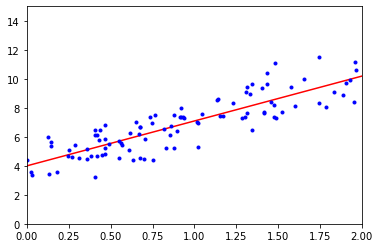

In [15]:
## Predicting 
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta)
y_predict

## Ploting the model predictions
plt.plot(X_new,y_predict,"r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])

In [20]:
def check_learning_rate(eta):
    theta = np.random.randn(2,1)
    n_iterations = 1000 #number of adjustments to the paramters
    m = 100 #number of variables
    for iterations in range(n_iterations):
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) ##Calculating the partial derivative
        theta = theta - eta*gradients ##adjustign the paramters based on the derivative and learning rate
    X_new = np.array([[0],[2]])
    X_new_b = np.c_[np.ones((2,1)),X_new]
    y_predict = X_new_b.dot(theta)
    ## Ploting the model predictions
    plt.plot(X_new,y_predict,"r-")
    plt.plot(X,y,"b.")
    plt.axis([0,2,0,15])
    plt.title(''.join(['Learning Rate = ', str(eta)]))

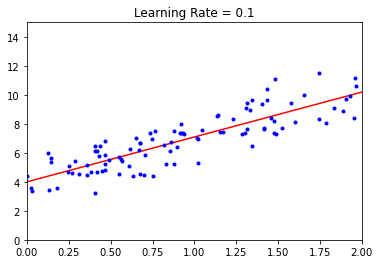

In [21]:
check_learning_rate(0.1)

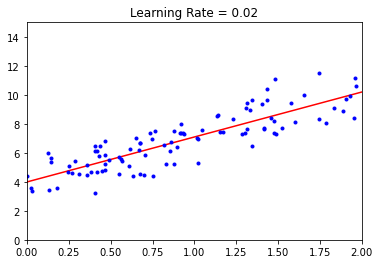

In [22]:
check_learning_rate(0.02)

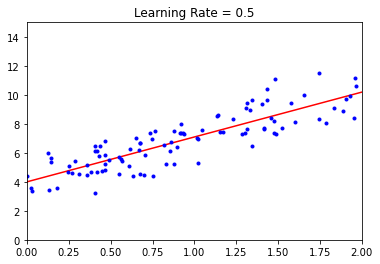

In [23]:
check_learning_rate(0.5)

<ipython-input-20-f0e699fa0a08>:7: RuntimeWarning: invalid value encountered in subtract
  theta = theta - eta*gradients ##adjustign the paramters based on the derivative and learning rate


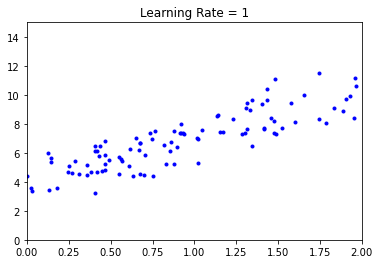

In [24]:
check_learning_rate(1)

<ipython-input-20-f0e699fa0a08>:7: RuntimeWarning: invalid value encountered in subtract
  theta = theta - eta*gradients ##adjustign the paramters based on the derivative and learning rate


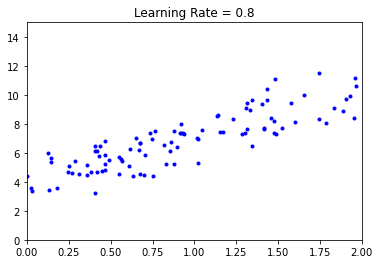

In [25]:
check_learning_rate(0.8)

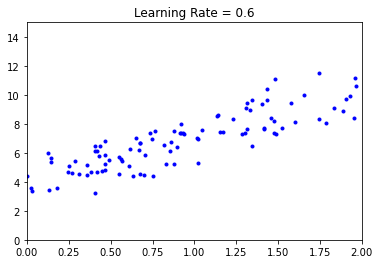

In [26]:
check_learning_rate(0.6)

- When the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. 
- When the learning rate looks is optimal:in just a few iterations, it has already converged to the solution. 
- WHen the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step.

Setting the iterations: set the number of iterations too high, and interupt the GD when the vector bcomes too tiny. 